In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
donors_df = pd.read_csv("noisy_synthetic_donors.csv")
recipients_df = pd.read_csv("noisy_synthetic_recipients.csv")

def preprocess(df, is_donor=True):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    if is_donor:
        df['availability_date'] = pd.to_datetime(df['availability_date'], errors='coerce')
    df.fillna({'medical_conditions': 'NONE'}, inplace=True)
    for col in ['gender', 'blood_type', 'location', 'medical_conditions']:
        df[col] = df[col].str.strip().str.upper()
    return df

donors_df = preprocess(donors_df, is_donor=True)
recipients_df = preprocess(recipients_df, is_donor=False)

In [3]:
donors_df['key'] = 1
recipients_df['key'] = 1
pairs_df = pd.merge(donors_df, recipients_df, on='key', suffixes=('_donor', '_recipient')).drop('key', axis=1)



In [8]:
def blood_compatible_noisy(donor_bt, recipient_bt):
    if random.blood_compatible() < 0.7:
        compatible = {
            'O-': ['O-', 'O+', 'A-', 'A+', 'B-', 'B+', 'AB-', 'AB+'],
            'O+': ['O+', 'A+', 'B+', 'AB+'],
            'A-': ['A-', 'A+', 'AB-', 'AB+'],
            'A+': ['A+', 'AB+'],
            'B-': ['B-', 'B+', 'AB-', 'AB+'],
            'B+': ['B+', 'AB+'],
            'AB-': ['AB-', 'AB+'],
            'AB+': ['AB+']
        }
        return int(recipient_bt in compatible.get(donor_bt, []))
    else:
        return int(not recipient_bt in compatible.get(donor_bt, []))

In [9]:
pairs_df['age_diff'] = abs(pairs_df['age_donor'] - pairs_df['age_recipient'])

pairs_df['gender_match'] = (pairs_df['gender_donor'] == pairs_df['gender_recipient']).astype(int)
gender_flip_idx = pairs_df.sample(frac=0.2, random_state=24).index
pairs_df.loc[gender_flip_idx, 'gender_match'] = 1 - pairs_df.loc[gender_flip_idx, 'gender_match']

pairs_df['location_match'] = (pairs_df['location_donor'] == pairs_df['location_recipient']).astype(int)
location_flip_idx = pairs_df.sample(frac=0.2, random_state=42).index
pairs_df.loc[location_flip_idx, 'location_match'] = 1 - pairs_df.loc[location_flip_idx, 'location_match']

pairs_df['blood_match'] = pairs_df.apply(
    lambda row: blood_compatible(row['blood_type_donor'], row['blood_type_recipient']), axis=1
)

pairs_df['has_conflict'] = (pairs_df['medical_conditions_donor'] == pairs_df['medical_conditions_recipient']).astype(int)


In [10]:
pairs_df['label'] = ((pairs_df['blood_match'] == 1) & (pairs_df['location_match'] == 1)).astype(int)
label_flip_idx = pairs_df.sample(frac=0.1, random_state=99).index
pairs_df.loc[label_flip_idx, 'label'] = 1 - pairs_df.loc[label_flip_idx, 'label']


In [11]:
features = ['age_diff', 'gender_match', 'location_match', 'blood_match', 'has_conflict']
X = pairs_df[features]
y = pairs_df['label']


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [14]:
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)



Epoch 1/10


80000/80000 [==============================] - 86s 1ms/step - loss: 0.3331 - accuracy: 0.8987 - val_loss: 0.3253 - val_accuracy: 0.9002
Epoch 2/10
80000/80000 [==============================] - 83s 1ms/step - loss: 0.3314 - accuracy: 0.8979 - val_loss: 0.3250 - val_accuracy: 0.9002
Epoch 3/10
80000/80000 [==============================] - 83s 1ms/step - loss: 0.3313 - accuracy: 0.8981 - val_loss: 0.3248 - val_accuracy: 0.9002
Epoch 4/10
80000/80000 [==============================] - 80s 1ms/step - loss: 0.3311 - accuracy: 0.8983 - val_loss: 0.3249 - val_accuracy: 0.9002
Epoch 5/10
80000/80000 [==============================] - 80s 999us/step - loss: 0.3310 - accuracy: 0.8987 - val_loss: 0.3247 - val_accuracy: 0.9002
Epoch 6/10
80000/80000 [==============================] - 79s 986us/step - loss: 0.3311 - accuracy: 0.8987 - val_loss: 0.3249 - val_accuracy: 0.9002
Epoch 7/10
80000/80000 [==============================] - 79s 986us/step - loss: 0.3311 - accuracy: 0.8985 - va

In [20]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"Accuracy: {acc:.4f}")
print(f"MSE: {mse:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"\nConfusion Matrix:\nTP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

6250/6250 [==============================] - 4s 653us/step
Accuracy: 0.9002
MSE: 0.0899

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94    162790
           1       0.90      0.52      0.66     37210

    accuracy                           0.90    200000
   macro avg       0.90      0.75      0.80    200000
weighted avg       0.90      0.90      0.89    200000


Confusion Matrix:
TP: 19365, TN: 160667, FP: 2123, FN: 17845


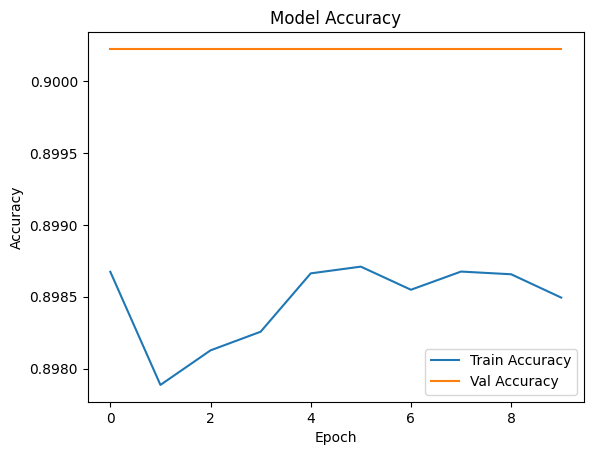

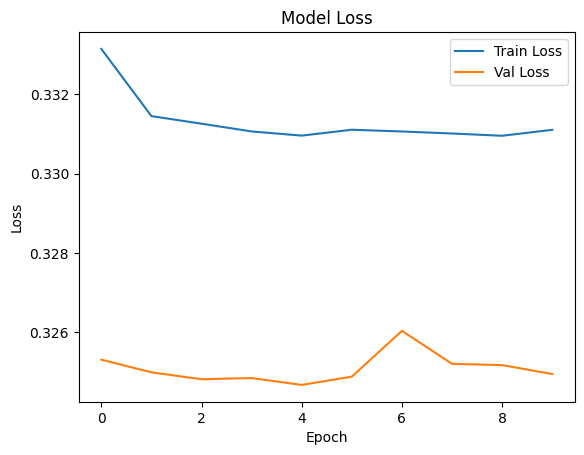

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


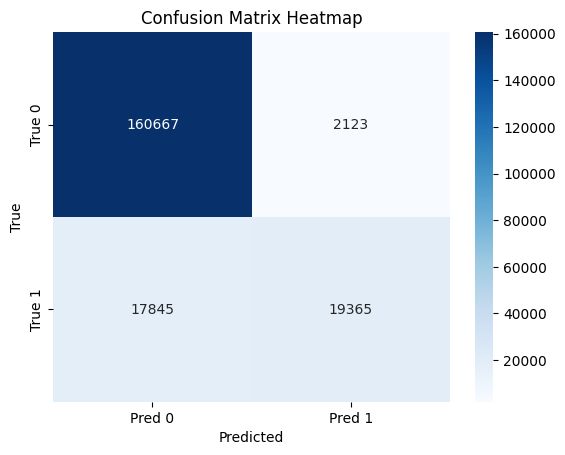

In [18]:
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
from tensorflow.keras.models import load_model

model.save("donor_match.h5")

c:\Users\ZeK0\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
